## Tracks ripple participation probability over epochs

In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [36]:
def compress_repeated_epochs(epoch_df):
    match = np.zeros([epoch_df.environment.shape[0]])
    match[match == 0] = np.nan
    for i,ep in enumerate(epoch_df.environment[:-1]):
        if np.isnan(match[i]):
            # find match in current and next epoch
            if ep == epoch_df.environment.iloc[i+1]:
                match[i:i+2] = i
                # given match, see if there are more matches
                for match_i in np.arange(1,epoch_df.environment[:-1].shape[0]):
                    if i+1+match_i == epoch_df.environment.shape[0]:
                        break
                    if ep == epoch_df.environment.iloc[i+1+match_i]:

                        match[i:i+1+match_i+1] = i
                    else:
                        break

    for i in range(len(match)):
        if np.isnan(match[i]):
            match[i] = (i+1)*2000 # make nans large numbers that are unlikely to be real epoch

    # iter through each epoch indicator to get start and stop
    results = pd.DataFrame()
    no_nan_match = match[~np.isnan(match)]
    for m in pd.unique(no_nan_match):
        temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                    'startTime':epoch_df[match==m].startTime.iloc[0],
                    'stopTime':epoch_df[match==m].stopTime.iloc[-1],
                    'environment':epoch_df[match==m].environment.iloc[0],
                    'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
    }
        temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

        results = results.append(temp_df,ignore_index=True)
    return results
    
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # create spike train object with ripple epochs
    st_unit_rip = st_unit[ripple_epochs]

    epochs = epoch_df.environment
    familiarity = epoch_df.behavioralParadigm

    for i,ep in enumerate(behavioral_epochs):
        temp_save = pd.DataFrame()

        unit_mat = get_participation(st_unit_rip[ep],
                                        ripple_epochs[ep])

        participation_prob = np.sum(unit_mat,axis=1) / unit_mat.shape[1]

        try:
            avg_fr_not_rip = st_unit[~ripple_epochs][ep].n_spikes / ep[~ripple_epochs].duration
            avg_fr_in_rip = st_unit_rip[ep].n_spikes / st_unit_rip[ep].support.duration
            n_spikes = st_unit[ep].n_spikes
        except:
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        if participation_prob.shape[0] == 0:
            participation_prob = np.nan
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        # package results and previously saved metrics
        temp_save['UID'] = cell_metrics.UID
        temp_save['basepath'] = basepath
        temp_save['epoch'] = epochs[i]
        temp_save['epoch_n'] = i
        temp_save['familiarity'] = familiarity[i]
        temp_save['deepSuperficial'] = cell_metrics.deepSuperficial
        temp_save['brainRegion'] = cell_metrics.brainRegion
        temp_save['putativeCellType'] = cell_metrics.putativeCellType
        temp_save['participation_prob'] = participation_prob
        temp_save['avg_fr_not_rip'] = avg_fr_not_rip
        temp_save['avg_fr_in_rip'] = avg_fr_in_rip
        temp_save['n_spikes'] = n_spikes
        temp_save['session_dur'] = ep.duration

        df_save = df_save.append(temp_save,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]
    
    if cell_metrics.shape[0] == 0:
        return

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    epoch_df = loading.load_epoch(basepath)
    # some epochs will have repeating back to back sessions that are actually the same session
    epoch_df = compress_repeated_epochs(epoch_df)

    behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df)
    df_save.to_csv(save_file)

def participation_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)       

In [37]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability'
df = df.loc[df['basepath'].str.contains("Kenji", case=False)]
participation_run(df,save_path,parallel=True)

In [180]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(save_path)

# restrict to units with >=50 spikes per epoch
for basepath in df.basepath.unique():
    good = []
    for ep in df[df.basepath == basepath].epoch_n.unique():
        good.append(df[(df.basepath == basepath) & (df.epoch_n==ep)].n_spikes >= 25)

    idx = np.vstack(good).sum(axis=0) == df[(df.basepath == basepath)].epoch_n.unique().shape[0]
    idx = np.hstack([idx]*df[(df.basepath == basepath)].epoch_n.unique().shape[0])
    df.loc[df.basepath == basepath, 'unit_quality'] = idx
df = df[df.unit_quality]
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,unit_quality
29,29,36,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,CA1,Pyramidal Cell,0.110236,0.514660,4.045123,845.0,1441.7540,True
61,61,36,Z:\Data\Kenji\2006-4-10,linearTwo,1,10,Deep,CA1,Pyramidal Cell,0.048287,1.626957,1.076069,2395.0,1490.3240,True
93,93,36,Z:\Data\Kenji\2006-4-10,Open,2,10,Deep,CA1,Pyramidal Cell,0.083451,0.909781,2.138122,1617.0,1705.9960,True
125,125,36,Z:\Data\Kenji\2006-4-10,sleep,3,10,Deep,CA1,Pyramidal Cell,0.085964,0.263007,1.677106,1113.0,3565.0010,True
157,157,36,Z:\Data\Kenji\2006-4-10,linearTwo,4,10,Deep,CA1,Pyramidal Cell,0.013216,0.060002,0.186328,92.0,1499.3840,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15683,111,31,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.066334,0.134450,1.384265,2520.0,15573.4079,True
15684,112,32,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.024732,0.193009,0.436982,3089.0,15573.4079,True
15686,114,35,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.046012,0.089808,0.985409,1704.0,15573.4079,True
15689,117,40,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.017446,0.017397,0.501503,436.0,15573.4079,True


# remove sleep epochs

In [181]:
df = df[df.epoch != 'sleep']
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,unit_quality
29,29,36,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,CA1,Pyramidal Cell,0.110236,0.514660,4.045123,845.0,1441.754,True
61,61,36,Z:\Data\Kenji\2006-4-10,linearTwo,1,10,Deep,CA1,Pyramidal Cell,0.048287,1.626957,1.076069,2395.0,1490.324,True
93,93,36,Z:\Data\Kenji\2006-4-10,Open,2,10,Deep,CA1,Pyramidal Cell,0.083451,0.909781,2.138122,1617.0,1705.996,True
157,157,36,Z:\Data\Kenji\2006-4-10,linearTwo,4,10,Deep,CA1,Pyramidal Cell,0.013216,0.060002,0.186328,92.0,1499.384,True
189,189,36,Z:\Data\Kenji\2006-4-10,linearOne,5,10,Deep,CA1,Pyramidal Cell,0.038462,1.214899,1.144424,1337.0,1100.756,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,70,31,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.125000,0.734663,2.447361,4084.0,5525.674,True
15643,71,32,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.030172,0.125921,0.489472,701.0,5525.674,True
15645,73,35,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.375000,2.161168,10.418766,12060.0,5525.674,True
15648,76,40,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.081897,0.137534,1.818040,784.0,5525.674,True


In [201]:
keep = []
for basepath in df.basepath:
    keep.append(df[(df.basepath == basepath)].epoch.unique().shape[0] > 1) 

df = df[keep]
df    

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,unit_quality
29,29,36,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,CA1,Pyramidal Cell,0.110236,0.514660,4.045123,845.0,1441.754,True
61,61,36,Z:\Data\Kenji\2006-4-10,linearTwo,1,10,Deep,CA1,Pyramidal Cell,0.048287,1.626957,1.076069,2395.0,1490.324,True
93,93,36,Z:\Data\Kenji\2006-4-10,Open,2,10,Deep,CA1,Pyramidal Cell,0.083451,0.909781,2.138122,1617.0,1705.996,True
157,157,36,Z:\Data\Kenji\2006-4-10,linearTwo,4,10,Deep,CA1,Pyramidal Cell,0.013216,0.060002,0.186328,92.0,1499.384,True
189,189,36,Z:\Data\Kenji\2006-4-10,linearOne,5,10,Deep,CA1,Pyramidal Cell,0.038462,1.214899,1.144424,1337.0,1100.756,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,282,110,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.207705,1.344257,6.436787,3331.0,2352.000,True
14952,283,111,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.102178,0.136711,2.346119,395.0,2352.000,True
14953,284,112,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.075377,0.186307,1.894942,495.0,2352.000,True
14954,285,113,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.065327,0.381671,1.955099,950.0,2352.000,True


In [202]:
print(df.epoch.unique())
print(df.epoch_n.unique())
print(df.familiarity.unique())
# print(df.basepath.unique())

['linearOne' 'linearTwo' 'Open' 'Tmaze' 'wheel' 'bigSquare' 'linear'
 'Mwheel' 'plus' 'midSquare' 'bigSquarePlus' 'wheel_home']
[0 1 2 4 5 6 3 7]
[10  1  2  3  4  7  6  8  9]


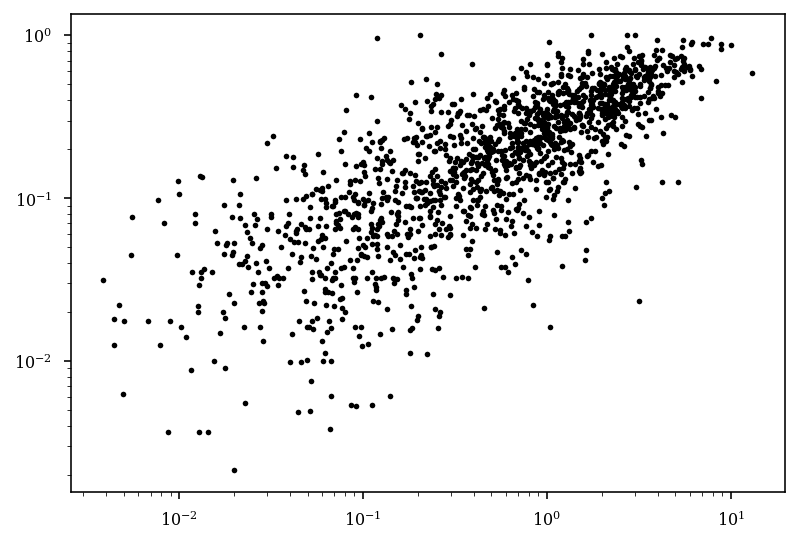

In [203]:
plt.plot(df.avg_fr_not_rip,df.participation_prob,'.k')
plt.xscale("log")
plt.yscale("log")


In [215]:
# basepath = df.basepath.unique()[0]
basepath = df[np.array(n_units)>=7].basepath.unique()[2]
print(basepath)
epoch_df = loading.load_epoch(basepath)

temp_df = df[df.basepath == basepath]
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values

Z:\Data\Kenji\ec013.370_390


Text(0.5, -0.9997600000000038, 'epoch')

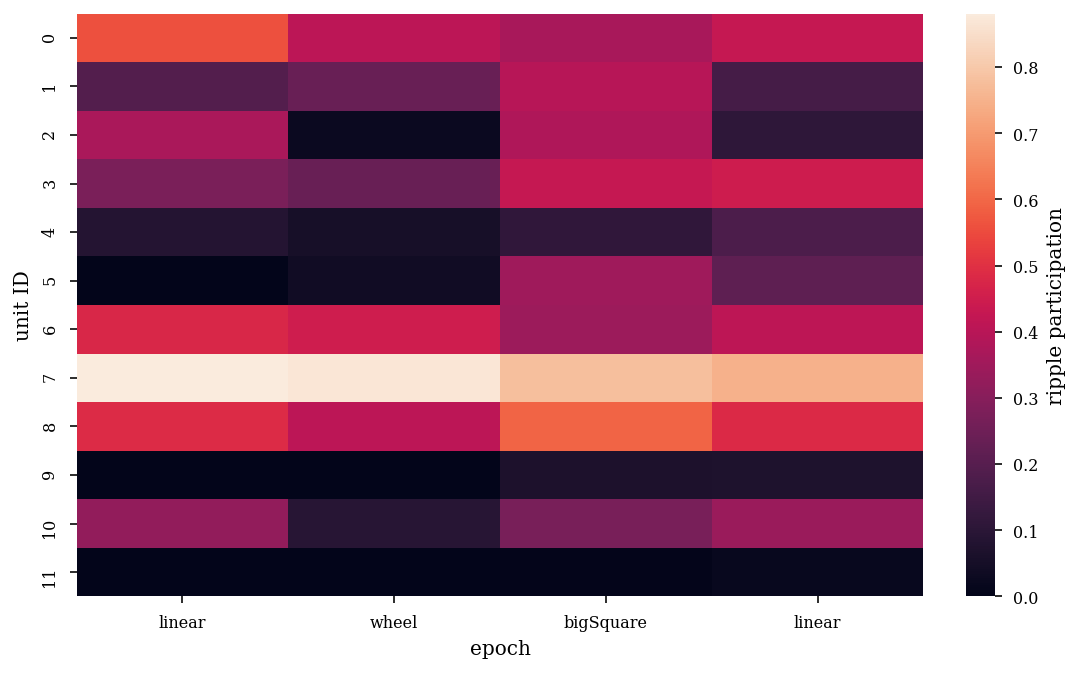

In [216]:
epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]

X_df = pd.DataFrame(index = np.arange(X.shape[1]), columns = epoch_name)
X_df[:] = X.T

# plt.figure(figsize=(15,8))
plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
sns.heatmap(X_df,cbar_kws={'label': 'ripple participation'})
plt.ylabel('unit ID')
plt.xlabel('epoch')

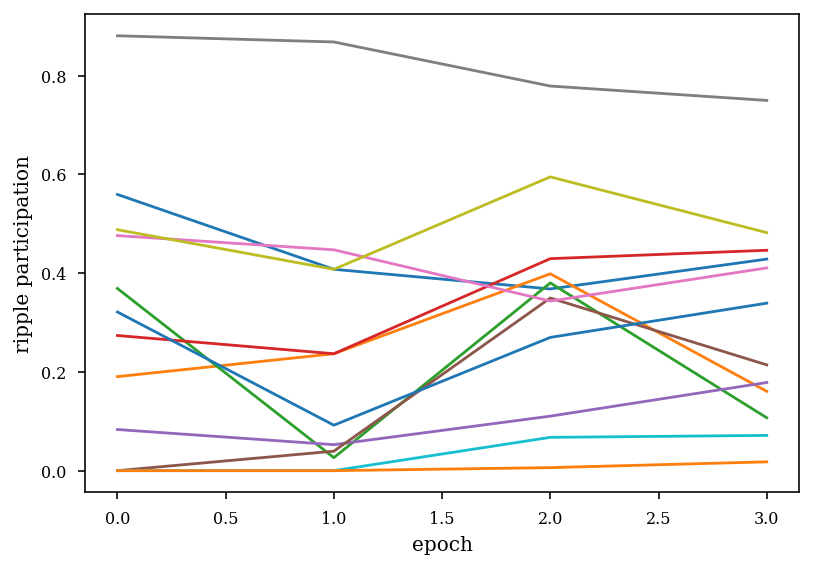

In [217]:
plt.plot(X_df.values.T)
plt.ylabel('ripple participation')
plt.xlabel('epoch')
plt.show()

In [205]:
n_units = []
for basepath in df.basepath:
    n_units.append(df[(df.basepath == basepath) & (df.epoch_n == df[df.basepath == basepath].epoch_n.iloc[0])].shape[0])

In [198]:
def pairwise_corr(df):
    x = df.epoch_n.unique()
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(df[df.epoch_n==s[0]].participation_prob,
                                        df[df.epoch_n==s[1]].participation_prob)
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c


df_save = pd.DataFrame()
for basepath in df[np.array(n_units)>=7].basepath.unique():
    if df[(df.basepath == basepath)].epoch_n.unique().shape[0] > 1:
        rho,pval,c = pairwise_corr(df[(df.basepath == basepath)])

        temp_df = pd.DataFrame()

        temp_df['ref'] = c[:,0]
        temp_df['target'] = c[:,1]
        temp_df['rho'] = rho
        temp_df['pval'] = pval
        temp_df['basepath'] = basepath

        df_save = df_save.append(temp_df,ignore_index=True)
df_save
# basepath = df[np.array(n_units)>=7].basepath.unique()[10]

# rho,pval,c = pairwise_corr(df[(df.basepath == basepath)])

# basepath = df[np.array(n_units)>=7].basepath.unique()[10]
# x1 = df[(df.basepath == basepath) & (df.epoch_n==0)].participation_prob
# x2 = df[(df.basepath == basepath) & (df.epoch_n==3)].participation_prob 
# plt.scatter(x1,x2)

# stats.spearmanr(x1,x2)
# sns.scatterplot(x="participation_prob", y="participation_prob",
#                 hue="epoch_n",
#                 sizes=(1, 8), linewidth=0,
#                 data=df[df.basepath == basepath])

,ref,target,rho,pval,basepath
0,1,2,1.000000,0.000000e+00,Z:\Data\Kenji\ec013.152_157
1,1,3,0.842424,2.220031e-03,Z:\Data\Kenji\ec013.194_213
2,1,3,0.835400,7.167851e-04,Z:\Data\Kenji\ec013.370_390
3,1,5,0.676073,1.579277e-02,Z:\Data\Kenji\ec013.370_390
4,1,6,0.767625,3.557617e-03,Z:\Data\Kenji\ec013.370_390
...,...,...,...,...,...
101,0,2,0.229622,4.504500e-01,Z:\Data\Kenji\i01_maze04_MS.001_003
102,0,2,0.521946,5.001885e-06,Z:\Data\Kenji\i01_maze05_MS.001_003
103,0,1,0.477707,5.956352e-04,Z:\Data\Kenji\i01_maze15_MS.001_004
104,0,2,0.519511,1.544166e-04,Z:\Data\Kenji\i01_maze15_MS.001_004


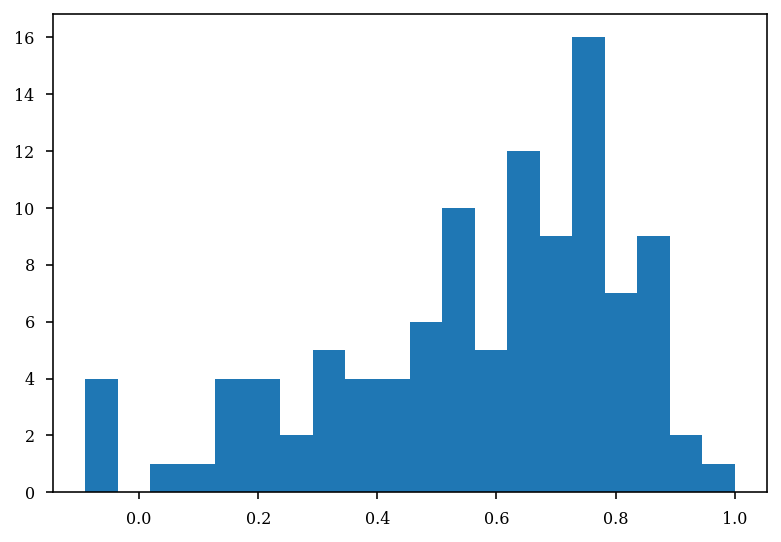

In [199]:
plt.hist(df_save.rho,20)
plt.show()

In [207]:
# for basepath in df[np.array(n_units)>=7].basepath.unique():
for basepath in df.basepath.unique():

    temp_df = df[df.basepath == basepath]
    epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]
    print(basepath,epoch_name)

Z:\Data\Kenji\2006-4-10 ['linearOne', 'linearTwo', 'Open', 'linearTwo', 'linearOne', 'Open']
Z:\Data\Kenji\2006-6-12 ['linearOne', 'linearTwo', 'Tmaze']
Z:\Data\Kenji\2006-6-13 ['linearOne', 'linearTwo', 'wheel', 'Tmaze']
Z:\Data\Kenji\2006-6-7 ['linearOne', 'linearTwo']
Z:\Data\Kenji\ec013.152_157 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.194_213 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.242_258 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.370_390 ['linear', 'wheel', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.393_418 ['linear', 'wheel', 'bigSquare', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.451_470 ['linear', 'bigSquare', 'linear', 'wheel']
Z:\Data\Kenji\ec013.480_509 ['Mwheel', 'plus', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.512_537 ['wheel', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.540_561 ['Mwheel', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.564_585 ['bigSquare', 'linear', 'wheel']
Z:\Data\Kenji\ec013.588_604 ['linear', 'wheel', 'bigSquare', 'linear', 'wheel']
Z:\Data\Kenj

Z:\Data\Kenji\ec013.393_418


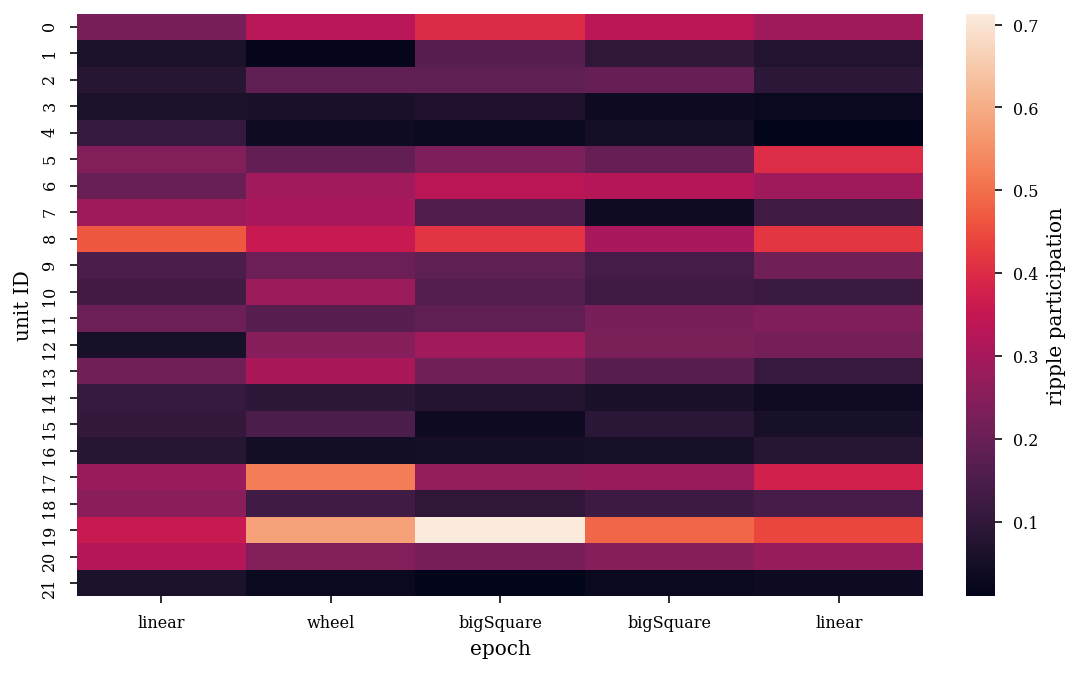

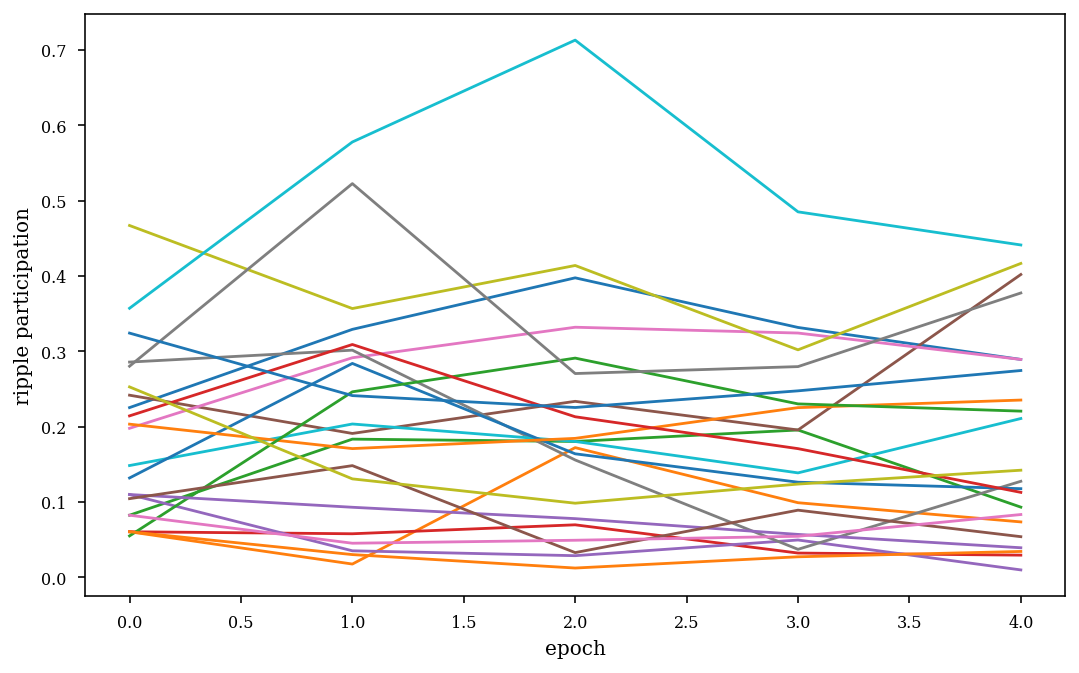

In [220]:
basepath = df[np.array(n_units)>=7].basepath.unique()[3]

print(basepath)
epoch_df = loading.load_epoch(basepath)

temp_df = df[df.basepath == basepath]
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values

epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]

X_df = pd.DataFrame(index = np.arange(X.shape[1]), columns = epoch_name)
X_df[:] = X.T

# plt.figure(figsize=(15,8))
plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
sns.heatmap(X_df,cbar_kws={'label': 'ripple participation'})
plt.ylabel('unit ID')
plt.xlabel('epoch')   

plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
plt.plot(X_df.values.T)
plt.ylabel('ripple participation')
plt.xlabel('epoch')
plt.show()

In [225]:
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=df,
    x="epoch_n", y="participation_prob",
    kind="line", col="basepath",hue="UID",
    height=3, aspect=1,col_wrap=6
)